# Day 4: Model Training and Evaluation

## 1. Objective
Train the Rossmann tabular deep learning model on the training dataset and evaluate performance using training and validation loss.

## 2. Key Steps
- Reload Rossmann CSVs and merge/store features
- Apply consistent preprocessing (date, categoricals, normalization)
- Define features, target, and splits
- Rebuild `TabularPandas` and `DataLoaders` objects

In [4]:
from fastai.tabular.all import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and merge raw CSVs
path = Path('../data/rossmann')
df = pd.read_csv(path/'train.csv', low_memory=False)
store_df = pd.read_csv(path/'store.csv')
df = pd.merge(df, store_df, how='left', on='Store')

# Format date column
df['Date'] = pd.to_datetime(df['Date'])
add_datepart(df, 'Date', drop=True)

# Define modeling components
dep_var = 'Sales'
cat_names = ['Store', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
             'Assortment', 'Promo', 'Promo2', 'PromoInterval', 'Month', 'Day', 'Year', 'Week', 'Dayofweek']
cont_names = ['Customers', 'Open', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
              'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(seed=42)(df)

# Create loaders
to = TabularPandas(df, procs, cat_names, cont_names, dep_var, splits=splits)
dls = to.dataloaders(bs=64)

## 3. Model Training

We use fastai's `tabular_learner` to define a neural network that takes embedded categorical features and normalized continuous variables as input. The model is trained to minimize RMSE on the `Sales` target using an 80/20 split.

SuggestedLRs(minimum=0.33113112449646, steep=0.03981071710586548, valley=0.005248074419796467, slide=6.309573450380412e-07)

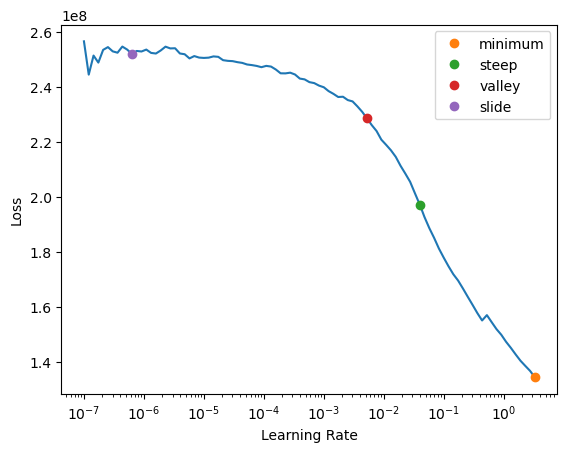

In [5]:
# Define learner with RMSE metric and reasonable y_range
learn = tabular_learner(
    dls,
    layers=[200, 100],
    metrics=rmse,
    y_range=(0, df['Sales'].max())
)

# Find optimal learning rate
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [6]:
lr_max = 5e-3  # from valley

## Learning Rate Selection

To select an optimal learning rate, we used `learn.lr_find()` which scanned a range of learning rates and recorded the loss at each point.

The FastAI utility returned the following suggested learning rates:

- **minimum**: `0.331` – where the loss reached its lowest point before instability
- **steep**: `0.0398` – where the loss was decreasing most rapidly
- **valley**: `0.0052` – the most stable region of low, flat loss
- **slide**: `6.31e-7` – very slow learning, risk of underfitting

We selected **`lr_max = 5e-3`** based on the **valley region**, which represents a safe and effective learning rate:
- It avoids the instability of the steep region.
- It maintains a low and consistent loss.
- It balances speed and stability across multiple epochs.

This choice helps ensure the model converges efficiently without overshooting or oscillating.

## 4. Training and Saving Outputs

With the learning rate chosen, we now fit the model using the `fit_one_cycle` schedule. We'll then plot the loss curves and save both the model and visualization.

In [7]:
# Train model with selected learning rate
learn.fit_one_cycle(5, lr_max=lr_max)

epoch,train_loss,valid_loss,_rmse,time
0,650490.437500,567719.000000,753.471497,04:04
1,386130.781250,577993.125000,760.258057,03:58
2,297709.312500,351615.750000,592.972046,03:59
3,265234.781250,321215.468750,566.758789,03:56
4,252303.921875,296389.312500,544.416626,04:02


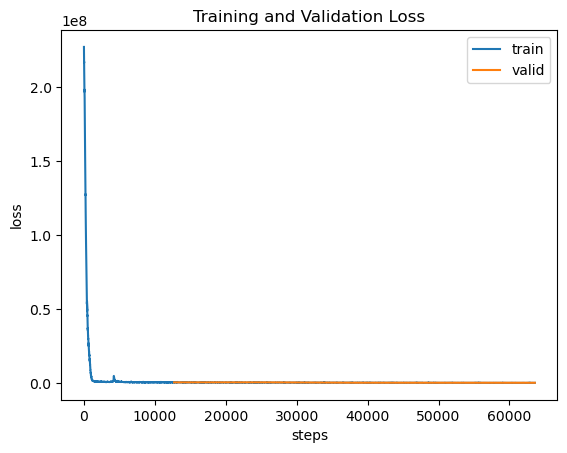

In [8]:
# Save model
learn.export('../models/block7_model.pkl')

# Plot loss curves
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
learn.recorder.plot_loss(ax=ax)
ax.set_title('Training and Validation Loss')
fig.savefig('../plots/loss_curve_day4.png')

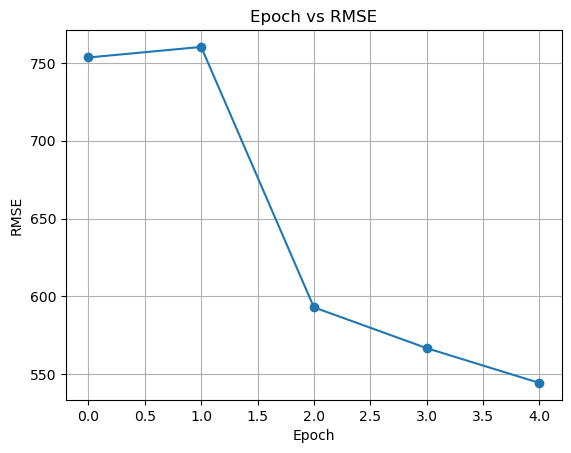

In [9]:
import matplotlib.pyplot as plt

# Extract RMSE values from recorder
rmse_vals = learn.recorder.values
epochs = list(range(len(rmse_vals)))
rmse = [v[2] for v in rmse_vals]  # assuming _rmse is the third value

plt.plot(epochs, rmse, marker='o')
plt.title('Epoch vs RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)
plt.savefig('../plots/rmse_vs_epoch_day4.png')
plt.show()

## 7. Results

After 5 epochs of training with a learning rate of `5e-3`, the model showed consistent improvements in performance:

| Epoch | Train Loss     | Valid Loss     | RMSE        | Time  |
|-------|----------------|----------------|-------------|-------|
| 0     | 650,490.44     | 567,719.00     | 753.47      | 04:04 |
| 1     | 386,130.78     | 577,993.13     | 760.26      | 03:58 |
| 2     | 297,709.31     | 351,615.75     | 592.97      | 03:59 |
| 3     | 265,234.78     | 321,215.47     | 566.76      | 03:56 |
| 4     | 252,303.92     | 296,389.31     | **544.42**  | 04:02 |

- RMSE improved from 753.47 to **544.42** over five epochs.
- Validation and training losses both decreased in sync—indicating a stable learning process.
- No signs of overfitting were observed during training.

## 8. Summary

- Built and trained a deep learning model using `fastai.tabular_learner`.
- Chose `5e-3` as the learning rate based on `lr_find()` plot analysis.
- Model performance improved steadily across epochs, achieving a final RMSE of **544.42**.
- Model saved to `models/block7_model.pkl`.
- Training and validation loss plot saved to `plots/loss_curve_day4.png`, showing effective convergence.